In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import csv
#shap requires this setting and tf.keras instead of keras to work
tf.compat.v1.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#read in the data
data = pd.read_feather(r'/media/kchen/2TB/kchen_backup/readm/data/procol_train.feather')
y = data['READMISSION1']
X = data.drop(['READMISSION1','CASEID'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
test = pd.read_feather(r'/media/kchen/2TB/kchen_backup/readm/data/procol_test.feather')
y_test = test['READMISSION1']
X_test = test.drop(['READMISSION1','CASEID'], axis=1)


In [27]:
data.shape

(213827, 114)

In [29]:
data['READMISSION1'].value_counts(normalize=True)

0    0.892048
1    0.107952
Name: READMISSION1, dtype: float64

In [4]:
#define the model
input_shape = [X_train.shape[1]]
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-3)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=1e-6,
    restore_best_weights=True,)

history = model4.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],)

ann_preds_readm = model4.predict(X_test)


Instructions for updating:
Colocations handled automatically by placer.
Train on 171061 samples, validate on 42766 samples


2022-01-12 13:03:50.744011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 13:03:50.752346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 13:03:50.752781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 13:03:50.753810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/200
167424/171061 [============================>.] - ETA: 0s - loss: 0.3779 - Sensitivity: 0.0302 - tn: 147089.0000 - auc: 0.6194 - prc: 0.1632

/home/kchen/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


171061/171061 [==============================] - 2s 14us/sample - loss: 0.3766 - Sensitivity: 0.0297 - tn: 150358.0000 - auc: 0.6199 - prc: 0.1633 - val_loss: 0.4269 - val_Sensitivity: 0.0000e+00 - val_tn: 38198.0000 - val_auc: 0.6505 - val_prc: 0.2177
Epoch 2/200
171061/171061 [==============================] - 2s 10us/sample - loss: 0.3278 - Sensitivity: 0.0192 - tn: 152100.0000 - auc: 0.6737 - prc: 0.2136 - val_loss: 0.3251 - val_Sensitivity: 0.0326 - val_tn: 38194.0000 - val_auc: 0.7065 - val_prc: 0.2895
Epoch 3/200
171061/171061 [==============================] - 2s 10us/sample - loss: 0.3212 - Sensitivity: 0.0352 - tn: 152187.0000 - auc: 0.6859 - prc: 0.2518 - val_loss: 0.3178 - val_Sensitivity: 0.0792 - val_tn: 38087.0000 - val_auc: 0.7142 - val_prc: 0.3009
Epoch 4/200
171061/171061 [==============================] - 2s 10us/sample - loss: 0.3160 - Sensitivity: 0.0570 - tn: 152157.0000 - auc: 0.6944 - prc: 0.2825 - val_loss: 0.3128 - val_Sensitivity: 0.0917 - val_tn: 38100.0000 

/home/kchen/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


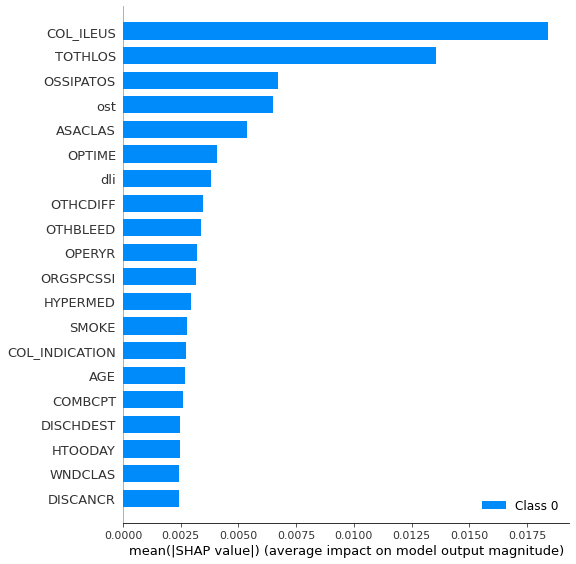

In [5]:
#calculate shap values
import shap
explainer = shap.DeepExplainer(model4, X_train.sample(n=4000))
shap_values = explainer.shap_values(X_valid.sample(n=4000).values)
shap.summary_plot(shap_values, X_valid.sample(n=4000))

In [6]:
#put the shap values into a dataframe
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
4,COL_ILEUS,0.018411
67,TOTHLOS,0.013570
74,OSSIPATOS,0.006724
106,ost,0.006477
65,ASACLAS,0.005372
66,OPTIME,0.004066
107,dli,0.003820
97,OTHCDIFF,0.003473
89,OTHBLEED,0.003363
12,OPERYR,0.003211


In [7]:
#export to excel where the variable names can be changed more easily
feature_importance.to_excel('shap.xlsx')

In [15]:
#read back into pandas
fi = pd.read_excel('shap.xlsx')

In [16]:
fi.head(10)

,Variable name,Relative importance
0,Ileus,0.018411
1,Index length of stay,0.013570
2,Organ-space SSI PATOS,0.006724
3,Ostomy placed (any type),0.006477
4,ASA classification,0.005372
5,Operative time (minutes),0.004066
6,Ileostomy placed,0.003820
7,C Diff infection,0.003473
8,Post-op transfusion,0.003363
9,Organ-space SSI,0.003175


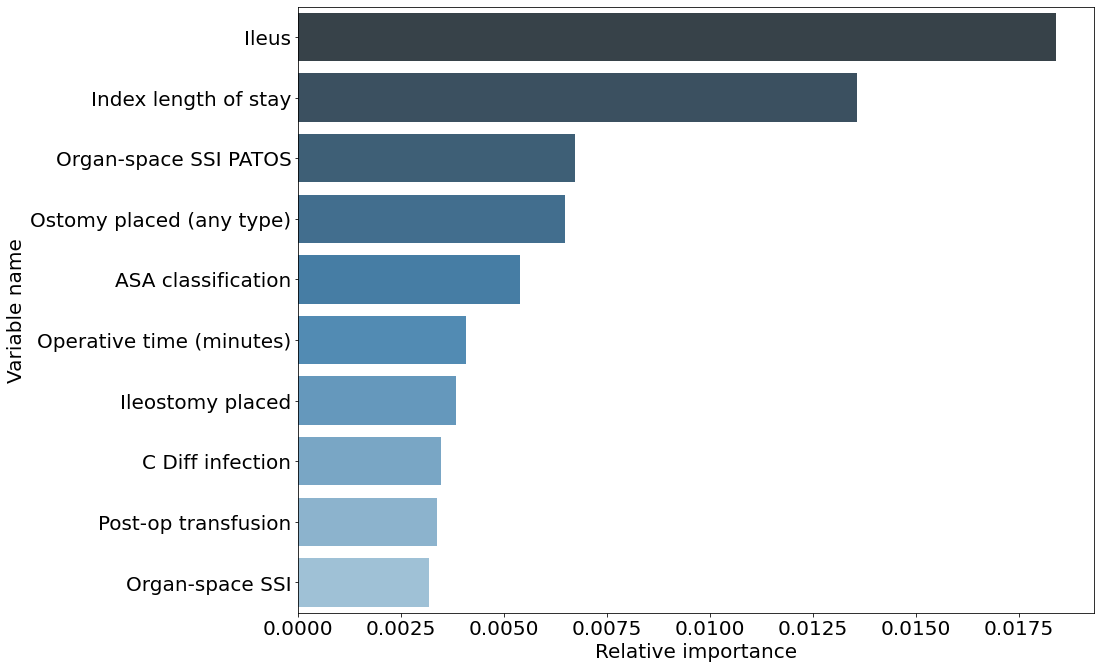

In [26]:
#plot the feature importance
import seaborn as sns
from matplotlib import pyplot as plt
palette = sns.color_palette("Blues_d", n_colors=10)
palette.reverse()
plt.figure(figsize=(16,10))
sns.barplot(x='Relative importance', y='Variable name', data=fi.head(10), palette=palette)
plt.rcParams["font.size"] = 30
plt.tight_layout()
plt.savefig('shap.png')